In [1]:
import torch
import torchvision
import timm
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from tqdm import tqdm
import os
os.chdir("/Users/zyxu/Documents/py/FM_weights")

model_names = timm.list_models('*vit*tiny*')
pprint(model_names)

/Users/zyxu/opt/anaconda3/envs/py39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['convit_tiny',
 'crossvit_tiny_240',
 'gcvit_tiny',
 'gcvit_xtiny',
 'gcvit_xxtiny',
 'maxvit_rmlp_tiny_rw_256',
 'maxvit_tiny_224',
 'maxvit_tiny_pm_256',
 'maxvit_tiny_rw_224',
 'maxvit_tiny_rw_256',
 'maxxvit_rmlp_tiny_rw_256',
 'mvitv2_tiny',
 'vit_tiny_patch16_224',
 'vit_tiny_patch16_224_in21k',
 'vit_tiny_patch16_384',
 'vit_tiny_r_s16_p8_224',
 'vit_tiny_r_s16_p8_224_in21k',
 'vit_tiny_r_s16_p8_384']


In [8]:
model = timm.create_model("vit_tiny_patch16_384", img_size=224,pretrained=True)
state_dict = model.state_dict()
num_heads = 3
model


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=768, out_features=192, bias=True)
        (drop2): Dropout(p=0.0, inplace=Fals

In [9]:
import torch

# Assuming model is your VisionTransformer instance
intermediate_outputs = []

# Hook function
def pre_forward_hook(module, input):
    intermediate_outputs.append(input[0].clone())

model.blocks[0].attn.register_forward_pre_hook(pre_forward_hook)

# Hook function to capture outputs
def forward_hook(module, input, output):
    intermediate_outputs.append(output.clone())

# Register the hook to capture the output after the initial patch embedding
# model.patch_embed.register_forward_hook(forward_hook)

# Register the forward hook after each block
for block in model.blocks:
    block.register_forward_hook(forward_hook)

In [10]:
# Now run your model with some data
input_tensor = torch.rand(64, 3, 224, 224)
model(input_tensor)

# The intermediate_outputs list should now contain the outputs before each attention layer
print(len(intermediate_outputs))  # Number of blocks with attention layers
print(intermediate_outputs[0].shape)  # Should be [64, 196, 192] or similar


13
torch.Size([64, 197, 192])


In [11]:
for i in intermediate_outputs:
    print(i.shape)


torch.Size([64, 197, 192])
torch.Size([64, 197, 192])
torch.Size([64, 197, 192])
torch.Size([64, 197, 192])
torch.Size([64, 197, 192])
torch.Size([64, 197, 192])
torch.Size([64, 197, 192])
torch.Size([64, 197, 192])
torch.Size([64, 197, 192])
torch.Size([64, 197, 192])
torch.Size([64, 197, 192])
torch.Size([64, 197, 192])
torch.Size([64, 197, 192])


In [12]:
h_total = torch.stack(intermediate_outputs)
h_total.shape

torch.Size([13, 64, 197, 192])

In [13]:
h_total.mean()

tensor(0.0573, grad_fn=<MeanBackward0>)

In [14]:
mu = h_total.mean(dim=(-1, -2, -3))
mu

tensor([-0.0045,  0.0825,  0.0718,  0.0704,  0.0739,  0.0721,  0.0693,  0.0689,
         0.0556,  0.0504,  0.0451,  0.0452,  0.0441], grad_fn=<MeanBackward1>)

In [34]:
expanded_mu_pos = mu.unsqueeze(1).unsqueeze(2).expand(-1, 197, 192)
pos = h_total.mean(1) - expanded_mu_pos
pos.shape

torch.Size([13, 197, 192])

In [38]:
expanded_mu_ctx = mu.unsqueeze(1).unsqueeze(2).expand(-1, 64, 192)

ctx = h_total.mean(2) - expanded_mu_ctx
ctx.shape

torch.Size([13, 64, 192])

In [40]:
expanded_pos = pos.unsqueeze(1).expand(-1, 64, -1, -1)
print(expanded_pos.shape)
expanded_ctx = ctx.unsqueeze(2).expand(-1, -1, 197, -1)
print(expanded_ctx.shape)

expanded_mu_whole = mu.unsqueeze(1).unsqueeze(2).unsqueeze(3).expand(-1, 64, 197, 192)
resid = h_total - expanded_mu_whole - expanded_pos - expanded_ctx
resid.shape

torch.Size([13, 64, 197, 192])
torch.Size([13, 64, 197, 192])


torch.Size([13, 64, 197, 192])

In [41]:
cvec = expanded_ctx + resid
cvec.shape

torch.Size([13, 64, 197, 192])

In [70]:
from utils.metrics import screenNOT
result = []
L, T, C = pos.shape
up_bound = 20
for l in tqdm(range(L)):
    p = pos[l].detach().numpy()
    rank = screenNOT(p, up_bound)
    result.append(rank)
    

100%|██████████| 13/13 [00:00<00:00, 98.17it/s]


In [71]:
result

[15, 15, 14, 12, 11, 12, 11, 11, 10, 11, 10, 9, 9]

## figure 2

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import seaborn as sns


def plot(pos_basis, context_basis, save_to=None):
    L, B, C = context_basis.shape
    L, T, C = pos_basis.shape
    nrows, ncols = 2, 6

    if L == 13:
        selected_layers = range(L - 1)
    else:
        selected_layers = list(np.linspace(0, L - 1, num=12, dtype=int))

    fig, axs = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows), dpi=100)
    for subplot_idx, layer_idx in enumerate(
        tqdm(selected_layers, desc="Layer Progress")
    ):
        rdx, cdx = subplot_idx // ncols, subplot_idx % ncols
        ax = axs[rdx, cdx]
        c = context_basis[layer_idx]
        c = F.normalize(c,dim = -1)
        p = pos_basis[layer_idx]
        p = F.normalize(p,dim = -1)
        
        combined = np.vstack([p, c])
        combined = combined / np.sqrt(np.sum(combined**2, axis=1, keepdims=True))
        g = combined @ combined.T
        vmax = np.max(g)
        sns.heatmap(
            g,
            vmin=-vmax,
            vmax=vmax,
            cmap="coolwarm",
            ax=ax,
            square=True,
            xticklabels=False,
            yticklabels=False,
            cbar_kws={"shrink": 0.7},
        )
        ax.tick_params(left=False, bottom=False)
        ax.set_title(f"Layer: {layer_idx}", weight="bold", fontsize=20)
    fig.tight_layout()

    if save_to is not None:
        plt.savefig(save_to, format="pdf", bbox_inches='tight')
        plt.close()
    else:
        plt.show()

Layer Progress: 100%|██████████| 12/12 [00:04<00:00,  2.75it/s]


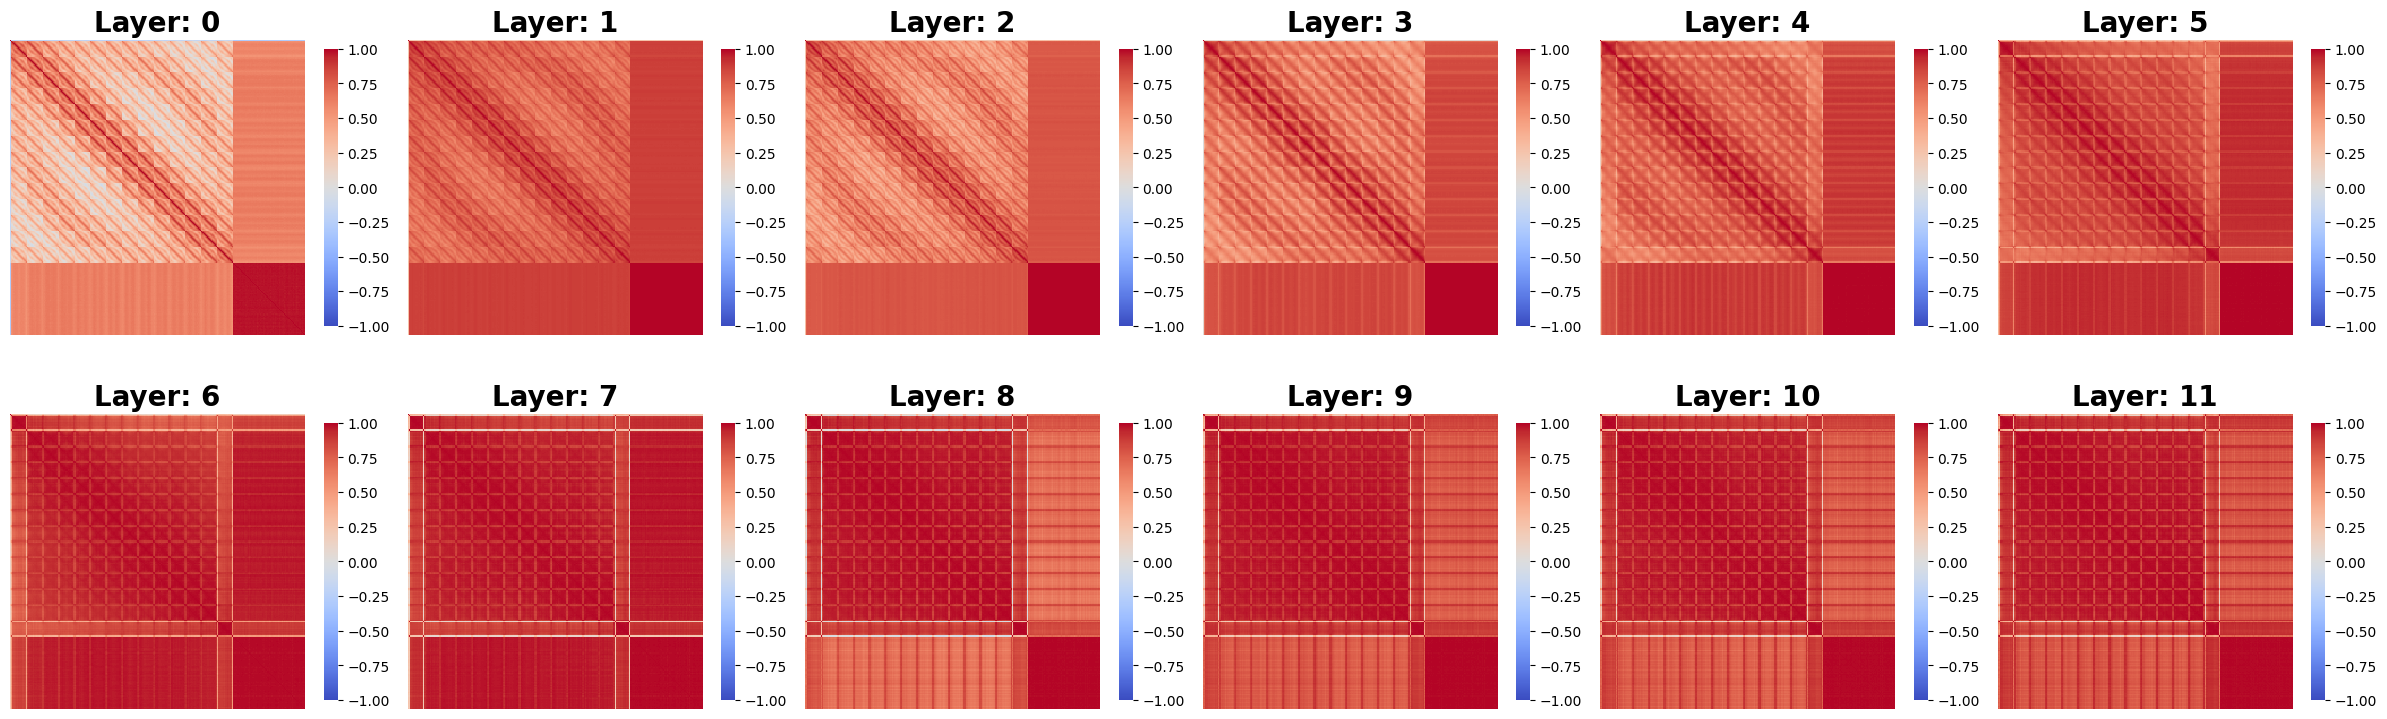

In [101]:
plot(pos.detach(),ctx.detach())

In [78]:
import torch.nn.functional as F

In [97]:
pos[0].shape

torch.Size([197, 192])

In [92]:
F.normalize(pos[0],dim = -1)

tensor([[-3.7004e-04, -1.5170e-02,  1.9740e-02,  ..., -7.7726e-03,
         -1.5043e-02, -8.9730e-03],
        [ 4.0646e-02,  3.7889e-02, -4.7109e-02,  ..., -1.5268e-02,
          4.0942e-03,  1.0712e-03],
        [ 4.5825e-02,  3.7099e-02,  3.8691e-02,  ..., -1.3399e-02,
         -2.9483e-04,  1.7019e-02],
        ...,
        [-8.0208e-02, -9.0060e-05, -2.9289e-02,  ..., -3.7367e-02,
          1.1051e-02, -1.1175e-02],
        [-5.5000e-02, -1.3098e-02, -3.7919e-03,  ...,  2.2527e-02,
         -2.6202e-02, -3.1508e-02],
        [-4.6779e-02,  2.0149e-02, -1.3723e-01,  ...,  1.2787e-02,
          2.5745e-02, -1.5744e-03]], grad_fn=<DivBackward0>)

In [93]:
F.normalize(pos[0],dim = -1).norm(dim = -1).shape

torch.Size([197])

In [95]:
ctx[0].shape

torch.Size([64, 192])

In [98]:
F.normalize(ctx[0],dim = -1).norm(dim = -1).shape

torch.Size([64])

### load

In [2]:
loaded_tensor = torch.load('/Users/zyxu/Documents/py/FM_weights/output/4sets_intermediate_outputs.pth')
print(loaded_tensor.shape)

torch.Size([13, 256, 197, 192])


In [3]:
from utils import intermdiates_to_pos_ctx
res = intermdiates_to_pos_ctx(loaded_tensor)
res.keys()

dict_keys(['mu', 'pos', 'ctx', 'resid', 'cvec'])

In [4]:
from utils import visz_gram_pos_cbasis

Layer Progress: 100%|██████████| 12/12 [00:07<00:00,  1.62it/s]


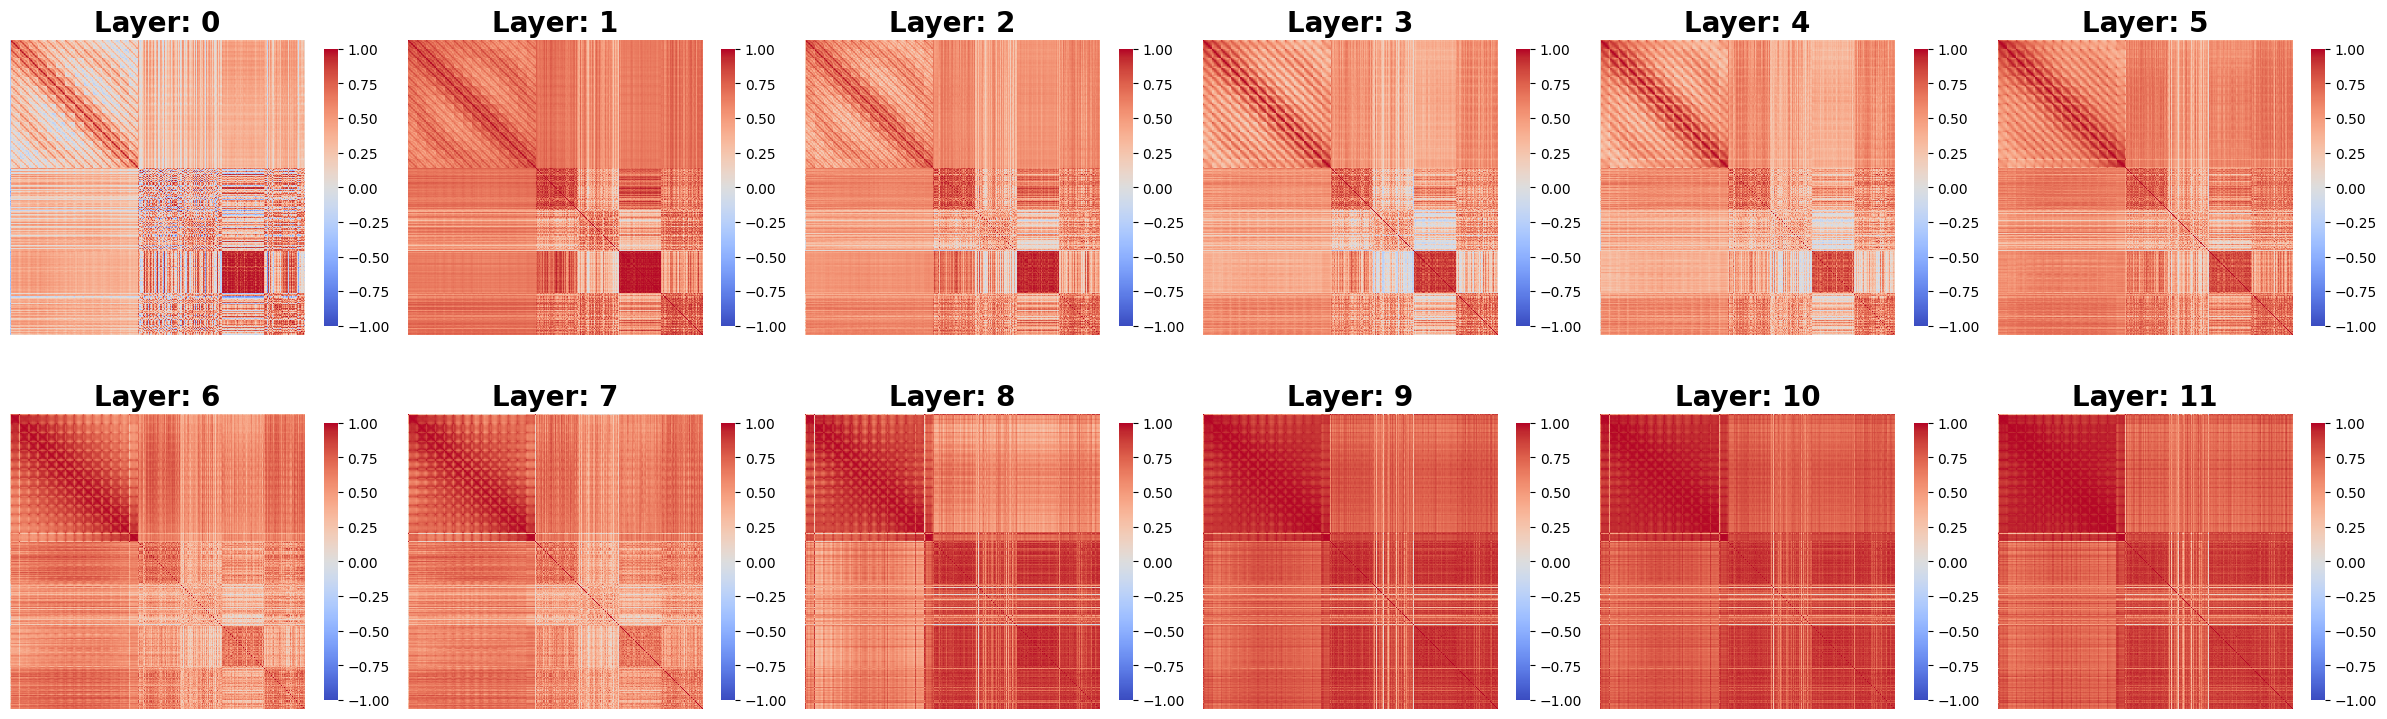

In [16]:
visz_gram_pos_cbasis(res['pos'].detach(),res['ctx'].detach(),)# save_to= "output/figure2.pdf")

Layer Progress: 100%|██████████| 12/12 [00:07<00:00,  1.59it/s]


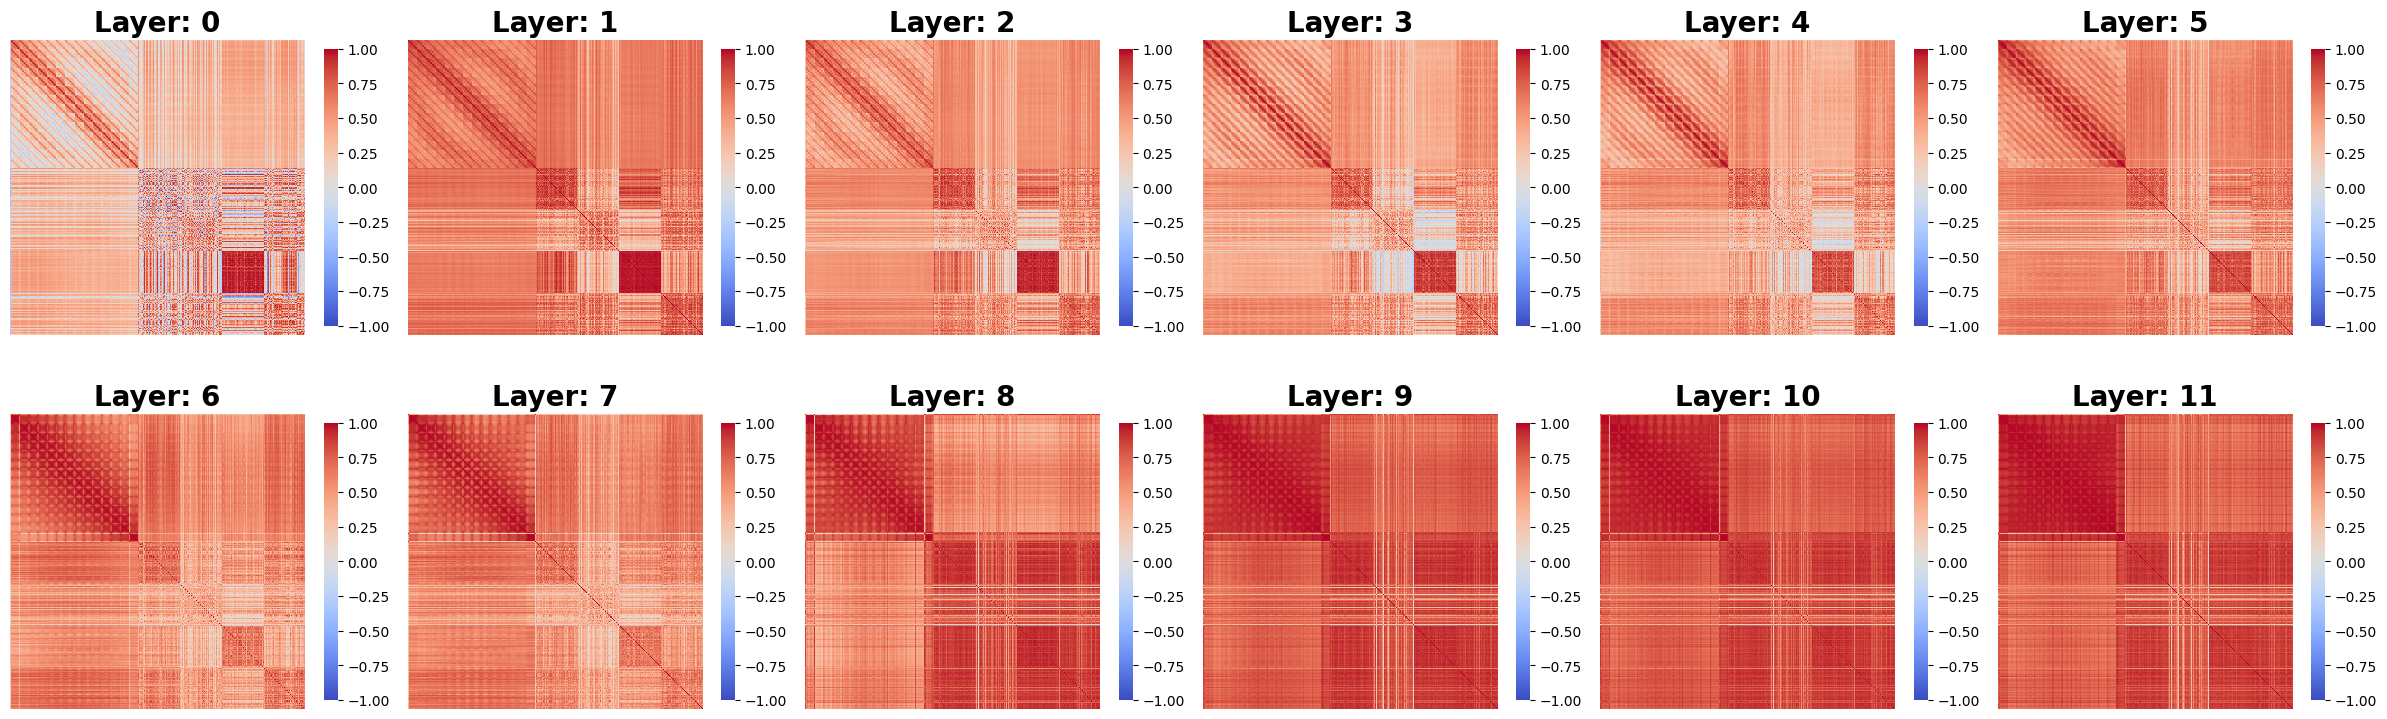

In [5]:
visz_gram_pos_cbasis(res['pos'].detach(),res['ctx'].detach(),)# save_to= "output/figure2.pdf")